<a href="https://colab.research.google.com/github/pourzand/Facial-Landmark-Detection-with-Deeplabv3-DSNT/blob/main/ashwhall%20Demo%20using%20DeepLabV3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import tensorflow as tf
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# DeepLab Imports
from keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Input,DepthwiseConv2D,add,Dropout,AveragePooling2D,Concatenate, Layer,InputSpec
from keras.models import Model														  
import keras.backend as K
# from keras.engine import Layer,InputSpec # This is from old keras/tf, 
from keras.utils import conv_utils


# Differentiable Spatial to Numerical Transform
An example of the usage of the DSNT layer, as taken from the paper "Numerical Coordinate Regression with Convolutional Neural Networks"

In [2]:

# DSNT Function(s)

'''
A Tensorflow implementation of the DSNT layer, as taken from the paper "Numerical Coordinate
Regression with Convolutional Neural Networks"
'''

def dsnt(inputs, method='softmax', output_range='0to1'):
    '''
    Differentiable Spatial to Numerical Transform, as taken from the paper "Numerical Coordinate
    Regression with Convolutional Neural Networks"
    Arguments: 
        inputs - The learnt heatmap. A 4d tensor of shape [batch, height, width, channels]
        method - A string representing the normalisation method. See `_normalise_heatmap` for available methods
        output_range - output range for x,y. please choose "0to1" (inclusive range) or "-1to1" (exclusive range)
            The paper chooses "-1to1" range which includes only numbers between -1 to 1, but exclude -1 and 1.
    Returns:
        norm_heatmap - The given heatmap with normalisation/rectification applied
        coords_zipped - A tensor of shape [batch, channels, 2] containing the [x, y] coordinate pairs for each heatmap
    Example:
        Usage as a Keras layer (ignoring heatmap): `keras.layers.Lambda(lambda x: dsnt.dsnt(x, 'softmax')[1])`
        Should directly follow a Conv2D layer with linear activation.
    '''
    # Rectify and reshape inputs
    norm_heatmap = _normalise_heatmap(inputs, method)
    
    batch_count = tf.shape(norm_heatmap)[0]
    height = tf.shape(norm_heatmap)[1]
    width = tf.shape(norm_heatmap)[2]
    channels = norm_heatmap.shape[3]

    if output_range == '0to1':
        gen_range = lambda length: tf.range(length) / (length-1)
    elif output_range == '-1to1':
        gen_range = lambda length: (2 * tf.range(1, length+1) - (length+1)) / length
    else:
        raise ValueError("Unknown output_range: " + str(output_range))

    # Build the DSNT x, y matrices
    dsnt_x = tf.reshape(gen_range(width), [1, 1, -1, 1])
    dsnt_x = tf.tile(dsnt_x, [batch_count, height, 1, channels])
    dsnt_x = tf.cast(dsnt_x, tf.float32)
    dsnt_y = tf.reshape(gen_range(height), [1, -1, 1, 1])
    dsnt_y = tf.tile(dsnt_y, [batch_count, 1, width, channels])
    dsnt_y = tf.cast(dsnt_y, tf.float32)

    # Compute the Frobenius inner product
    outputs_x = tf.reduce_sum(tf.multiply(norm_heatmap, dsnt_x), axis=[1, 2])
    outputs_y = tf.reduce_sum(tf.multiply(norm_heatmap, dsnt_y), axis=[1, 2])

    # Zip into [x, y] pairs
    coords_zipped = tf.stack([outputs_x, outputs_y], axis=-1)

    return norm_heatmap, coords_zipped

def js_reg_loss(heatmaps, centres, fwhm=1):
    '''
    Calculates and returns the average Jensen-Shannon divergence between heatmaps and target Gaussians.
    Arguments:
        heatmaps - Heatmaps generated by the model
        centres - Centres of the target Gaussians (in normalized units)
        fwhm - Full-width-half-maximum for the drawn Gaussians, which can be thought of as a radius.
    '''
    gauss = _make_gaussians(centres, tf.shape(heatmaps)[1], tf.shape(heatmaps)[2], fwhm)
    divergences = _js_2d(heatmaps, gauss)
    return tf.reduce_mean(divergences)


def _normalise_heatmap(inputs, method='softmax'):
    '''
    Applies the chosen normalisation/rectification method to the input tensor
    Arguments:
        inputs - A 4d tensor of shape [batch, height, width, channels] (the learnt heatmap)
        method - A string representing the normalisation method. One of those shown below
    '''
    # Remove the final dimension as it's of size 1
#     inputs = tf.reshape(inputs, tf.shape(inputs)[:3])

    # Normalise the values such that the values sum to one for each heatmap
    normalise = lambda x: tf.divide(x, tf.reduce_sum(x, axis=[1, 2], keepdims=True))

    # Perform rectification
    if method == 'softmax':
        inputs = _softmax2d(inputs, axes=[1, 2])
    elif method == 'abs':
        inputs = tf.abs(inputs)
        inputs = normalise(inputs)
    elif method == 'relu':
        inputs = tf.nn.relu(inputs)
        inputs = normalise(inputs)
    elif method == 'sigmoid':
        inputs = tf.nn.sigmoid(inputs)
        inputs = normalise(inputs)
    else:
        msg = "Unknown rectification method \"{}\"".format(method)
        raise ValueError(msg)
    return inputs

def _kl_2d(p, q, eps=24):
    unsummed_kl = p * (tf.log(p + eps) - tf.log(q + eps))
    kl_values = tf.reduce_sum(unsummed_kl, [-1, -2])
    return kl_values

def _js_2d(p, q, eps=1e-24):
    m = 0.5 * (p + q)
    return 0.5 * _kl_2d(p, m, eps) + 0.5 * _kl_2d(q, m, eps)

def _softmax2d(target, axes):
    '''
    A softmax implementation which can operate across more than one axis - as this isn't
    provided by Tensorflow
    Arguments:
        targets - The tensor on which to apply softmax
        axes - An integer or list of integers across which to apply softmax
    '''
    max_axis = tf.reduce_max(target, axes, keepdims=True)
    target_exp = tf.exp(target-max_axis)
    normalize = tf.reduce_sum(target_exp, axes, keepdims=True)
    softmax = target_exp / normalize
    return softmax

def _make_gaussian(size, centre, fwhm=1):
        '''
        Makes a rectangular gaussian kernel.
        Arguments:
            size - A 2d tensor representing [height, width]
            centre - Pair of (normalised [0, 1]) x, y coordinates 
            fwhm - Full-width-half-maximum, which can be thought of as a radius.
        '''
        # Scale the normalised coordinates to be relative to the size of the frame
        centre = [centre[0] * tf.cast(size[1], tf.float32), 
                  centre[1] * tf.cast(size[0], tf.float32)]
        # Find the largest side, as we build a square and crop to desired size
        square_size = tf.cast(tf.reduce_max(size), tf.float32)

        x = tf.range(0, square_size, 1, dtype=tf.float32)
        y = x[:,tf.newaxis]
        x0 = centre[0] - 0.5
        y0 = centre[1] - 0.5
        unnorm = tf.exp(-4*tf.log(2.) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)[:size[0],:size[1]]
        norm = unnorm / tf.reduce_sum(unnorm)
        return norm

def _make_gaussians(centres_in, height, width, fwhm=1):
    '''
    Makes a batch of gaussians. Size of images designated by height, width; number of images
    designated by length of the 1st dimension of centres_in
    Arguments:
        centres_in - The normalised coordinate centres of the gaussians of shape [batch, x, y]
        height - The desired height of the produced gaussian image
        width - The desired width of the produced gaussian image
        fwhm - Full-width-half-maximum, which can be thought of as a radius.
    '''
    def cond(centres, heatmaps):
        return tf.greater(tf.shape(centres)[0], 0)
    
    def body(centres, heatmaps):
        curr = centres[0]
        centres = centres[1:]
        new_heatmap = _make_gaussian([height, width], curr, fwhm)
        new_heatmap = tf.reshape(new_heatmap, [-1])
        
        heatmaps = tf.concat([heatmaps, new_heatmap], 0)
        return [centres, heatmaps]
    
    # Produce 1 heatmap per coordinate pair, build a list of heatmaps
    _, heatmaps_out = tf.while_loop(cond,
                                    body,
                                    [centres_in, tf.constant([])],
                                    shape_invariants=[tf.TensorShape([None, 2]), tf.TensorShape([None])])
    heatmaps_out = tf.reshape(heatmaps_out, [-1, height, width])
    return heatmaps_out

## Build some dummy data
Circles of random colour, size and position on a black background


200 images total
training: 150
testing : 50


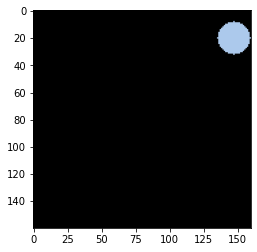

In [3]:
img_size = 160
image_count = 200
train_percent = 0.75
train_image_count = int(train_percent * image_count)
test_image_count = image_count - train_image_count

images = []
targets = []
for _ in range(200):
    img = np.zeros((img_size, img_size, 3))
    row, col = np.random.randint(0, img_size), np.random.randint(0, img_size)
    radius = np.random.randint(8, 15)
    b, g, r = np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)
    cv2.circle(img, (row, col), radius, (b, g, r), -1)
    images.append(img)
    norm_row = row / img_size
    norm_col = col / img_size
    targets.append([norm_row, norm_col])

images = np.array(images)
targets = np.array(targets)
train_images = images[:train_image_count]
test_images = images[train_image_count:]
train_targets = targets[:train_image_count]
test_targets = targets[train_image_count:]

print('''
{} images total
training: {}
testing : {}'''.format(image_count, train_image_count, test_image_count))

plt.imshow(train_images[0].astype('uint8'))

In [4]:
print(train_targets.shape)
print(train_targets[0])
num_classes =1 # aka the number of landmarks per image, in this case just 1 landmark since the landmark is 1 dot
train_targets = train_targets.reshape(train_targets.shape[0],num_classes,2)
# data should now be compatible with the deeplabv3 model

(150, 2)
[0.91875 0.125  ]


In [5]:
print(train_targets.shape)
print(train_targets[0][0])

(150, 1, 2)
[0.91875 0.125  ]


## A Simple FCN Model
Fully Connected Network with the final layer being the DSNT layer through the use of a keras lambda layer

In [194]:
# DeepLabV3+ model

class BilinearUpsampling(Layer):

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
            input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
            input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs): # replaced K.tf.image.resize_bilenear with compat.v1.image.resize_bilinearr
        return K.tf.compat.v1.image.resize_bilinear(inputs, (int(inputs.shape[1]*self.upsampling[0]),
                                                   int(inputs.shape[2]*self.upsampling[1])))

    def get_config(self):
        config = {'size': self.upsampling,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
def xception_downsample_block(x,channels,top_relu=False):
	##separable conv1
	if top_relu:
		x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	
	##separable conv2
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	
	##separable conv3
	x=DepthwiseConv2D((3,3),strides=(2,2),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	return x
def res_xception_downsample_block(x,channels):
	res=Conv2D(channels,(1,1),strides=(2,2),padding="same",use_bias=False)(x)
	res=BatchNormalization()(res)
	x=xception_downsample_block(x,channels)
	x=add([x,res])
	return x
def xception_block(x,channels):
	##separable conv1
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	
	##separable conv2
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	
	##separable conv3
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	return x	
def res_xception_block(x,channels):
	res=x
	x=xception_block(x,channels)
	x=add([x,res])
	return x
def aspp(x,input_shape,out_stride):
	b0=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	b0=BatchNormalization()(b0)
	b0=Activation("relu")(b0)
	
	b1=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
	b1=BatchNormalization()(b1)
	b1=Activation("relu")(b1)
	b1=Conv2D(256,(1,1),padding="same",use_bias=False)(b1)
	b1=BatchNormalization()(b1)
	b1=Activation("relu")(b1)
	
	b2=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
	b2=BatchNormalization()(b2)
	b2=Activation("relu")(b2)
	b2=Conv2D(256,(1,1),padding="same",use_bias=False)(b2)
	b2=BatchNormalization()(b2)
	b2=Activation("relu")(b2)	

	b3=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
	b3=BatchNormalization()(b3)
	b3=Activation("relu")(b3)
	b3=Conv2D(256,(1,1),padding="same",use_bias=False)(b3)
	b3=BatchNormalization()(b3)
	b3=Activation("relu")(b3)
	
	out_shape=int(input_shape[0]/out_stride)
	print("\noutput_shape: {} \n".format(out_shape))
	b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)

	b4=Conv2D(256,(1,1),padding="same",use_bias=False)(b4)
	b4=BatchNormalization()(b4)
	b4=Activation("relu")(b4)
	#out_shape+=1
	b4=BilinearUpsampling((out_shape,out_shape))(b4)
	print("shape {}".format(b4.shape))
	x=Concatenate()([b4,b0,b1,b2,b3])
	return x

def fcnModel(input_shape=(96,96,1),out_stride=16,num_classes=15):
	
	img_input=Input(shape=input_shape) # OG
	print("input shape is the following: {} {} {}".format(input_shape[0], input_shape[1],input_shape[2]))
	#print(input_shape[0], input_shape[1],input_shape[2]) # not OG
	# img_input = tf.compat.v1.placeholder(tf.float32, shape=[None, input_shape[0], input_shape[1],input_shape[2]]) # Not OG

	x=Conv2D(32,(3,3),strides=(2,2),padding="same",use_bias=False)(img_input)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Conv2D(64,(3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
    
	# x=Conv2D(128,(3,3),padding="same",use_bias=False)(x)#   }
	# x=BatchNormalization()(x)    #                          }>- all of this is not actually part of dlv3
	# x=Activation("relu")(x)     #                           }
    
    # Still Good Results above
    
	x=res_xception_downsample_block(x,128) # Results got a little worse(visually) with the addition of this, not as close to dot

    # Little worse with the addtion of this block, no longer on the dot, but nearby
    
	res=Conv2D(256,(1,1),strides=(2,2),padding="same",use_bias=False)(x)
	res=BatchNormalization()(res)	
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    
    
	skip=BatchNormalization()(x)
	x=Activation("relu")(skip)
	x=DepthwiseConv2D((3,3),strides=(2,2),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)	
	x=add([x,res])
	
	# x=xception_downsample_block(x,728,top_relu=True)#   }   
	# for i in range(16): #                               }>- this consistently hurts performance
	# 	x=res_xception_block(x,728)#                    }





	res=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
	res=BatchNormalization()(res)	
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(728,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)	
	x=add([x,res],name="last")
    
    # --- Here marks where the DSNT stops working with deeplab,
    # --- despite the heatmaps outputs still being accurate
	
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False,name="start")(x)
	x=BatchNormalization()(x)
	x=Conv2D(1536,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x) # ------ comment out below and works fine?
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(1536,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x) # ------ comment out below and works fine? ? ? ? ? ?
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Conv2D(2048,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)	
	x=Activation("relu")(x)

    
    
    
	#aspp
	x=aspp(x,input_shape,out_stride)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Dropout(0.9)(x)
	
	##decoder 
	x=BilinearUpsampling((2,2))(x) # Changed from (4,4) to (2,2) since i removed the downsample blocks
	dec_skip=Conv2D(48,(1,1),padding="same",use_bias=False)(skip)
	dec_skip=BatchNormalization()(dec_skip)
	dec_skip=Activation("relu")(dec_skip)
	x=Concatenate()([x,dec_skip])
	
	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
    
    
	
# 	x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
# 	x=BatchNormalization()(x)
# 	x=Activation("relu")(x)
# 	x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
# 	x=BatchNormalization()(x)
# 	x=Activation("relu")(x)
	
# 	x=Conv2D(num_classes,(1,1),padding="same")(x)
# 	x=BilinearUpsampling((4,4))(x)
# 	x = Activation("sigmoid",name='last')(x)
	

    # Random Notes:
    # Depthwise really hurts performance by a lot when using maxpooling but now its fine?, 
    # second worst is res_xception_downsample_block hurts performance as well but not as badly
    
    
    # DSNT Above, below norm
    
	# x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')   # Bring this back??
    # This pooling makes things quite weird when working with deeplab
    
# 	inputs = tf.keras.layers.Conv2D(filters=166,
#                         kernel_size=3,
#                         dilation_rate=1,
#                         padding='SAME',
#                         name='conv1')(img_input)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=32,
#                         kernel_size=3,
#                         dilation_rate=2,
#                         padding='SAME',
#                         name='conv2')(inputs)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=64,
#                         kernel_size=3,
#                         dilation_rate=4,
#                         padding='SAME',
#                         name='conv3')(inputs)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=128,
#                         kernel_size=3,
#                         dilation_rate=8,
#                         padding='SAME',
#                         name='conv4')(x) # used to be 'inputs'
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=256,
#                         kernel_size=3,
#                         dilation_rate=16,
#                         padding='SAME',
#                         name='conv5')(inputs)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=256,
#                         kernel_size=3,
#                         padding='SAME',
#                         name='conv6')(inputs)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    
    
	x = tf.keras.layers.Conv2D(filters=1,
	kernel_size=1,
	padding='SAME',
	name='conv7')(x)


    


    
	print("----------------")
	print("final shape of fcn model {}".format(inputs.shape))
	print("----------------")
	
# 	norm_heatmap, coords = dsnt(x)
	
# 	print("\nshape of normalized heatmap {}".format(norm_heatmap.shape))
# 	print("\nshape of coordinates {}".format (coords.shape))
    		
	x = tf.keras.layers.Lambda(lambda x: dsnt(x, 'softmax')[1])(x)
	model=Model(img_input,x)
	
	# print(type(model))
	# return model
	
	# i guess you cant make a keras model with the placeholders
	# model=Model(img_input2,norm_heatmap)
	
	return model

## Training
A very simple training loop with no mini-batching.

In [195]:
tf.compat.v1.disable_eager_execution()
model = fcnModel(input_shape=(160,160,3),out_stride=16,num_classes=1) # wasnt sure if num_classes is number of landmarks or 
#model.summary()

input shape is the following: 160 160 3

output_shape: 10 

shape (None, 20, 20, 256)
----------------
final shape of fcn model (None, 160, 160, 3)
----------------


In [196]:


# predictions, heatmaps = dsnt(x) # old usage of dsnt, ignore this
# # The predictions are in the range [-1, 1] but I prefer to work with [0, 1]
# predictions = (predictions + 1) / 2

# # Coordinate regression loss
# loss_1 = tf.losses.mean_squared_error(input_y, predictions)

# # Regularization loss
#   #normally would be dsnt.js_reg_loss
# loss_2 = js_reg_loss(heatmaps, input_y)
# loss = loss_1 + loss_2




callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# to Stop training if there is no improvements

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


model.fit(train_images, train_targets, batch_size=16, epochs=25, callbacks=[callback])


Train on 150 samples
Epoch 1/25
150/150 [==============================] - 29s 194ms/sample - loss: 0.0132 - accuracy: 0.8467
Epoch 2/25
150/150 [==============================] - 10s 64ms/sample - loss: 6.1023e-04 - accuracy: 0.9533
Epoch 3/25
150/150 [==============================] - 9s 59ms/sample - loss: 3.3467e-04 - accuracy: 0.9733
Epoch 4/25
150/150 [==============================] - 9s 60ms/sample - loss: 2.4583e-04 - accuracy: 0.9867
Epoch 5/25
150/150 [==============================] - 9s 59ms/sample - loss: 1.9078e-04 - accuracy: 0.9600
Epoch 6/25
150/150 [==============================] - 9s 61ms/sample - loss: 1.6852e-04 - accuracy: 0.9733
Epoch 7/25
150/150 [==============================] - 8s 57ms/sample - loss: 1.4834e-04 - accuracy: 0.9800
Epoch 8/25
150/150 [==============================] - 9s 61ms/sample - loss: 1.2424e-04 - accuracy: 0.9733
Epoch 9/25
150/150 [==============================] - 9s 59ms/sample - loss: 1.2908e-04 - accuracy: 0.9933
Epoch 10/25
150/1

In [197]:
test_targets = test_targets.reshape(test_targets.shape[0],num_classes,2)

results = model.evaluate(test_images, test_targets, batch_size=16)
print("test loss, test acc:", results)

test loss, test acc: [0.08258140027523041, 0.96]


In [198]:
print(test_targets.shape)
#model.summary()

(50, 1, 2)


(50, 20, 20, 1024)


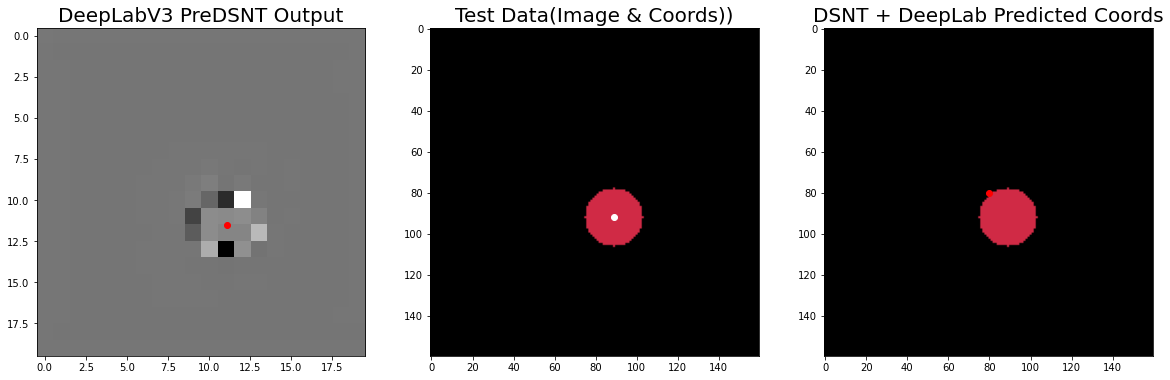

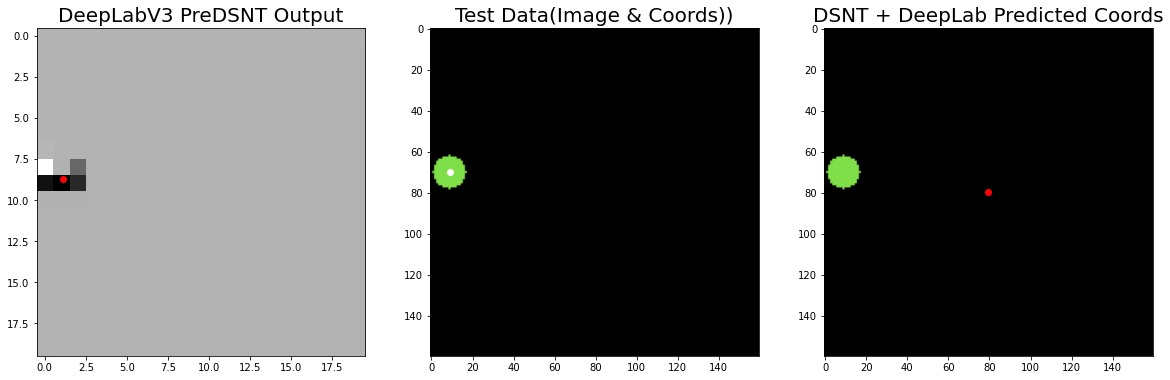

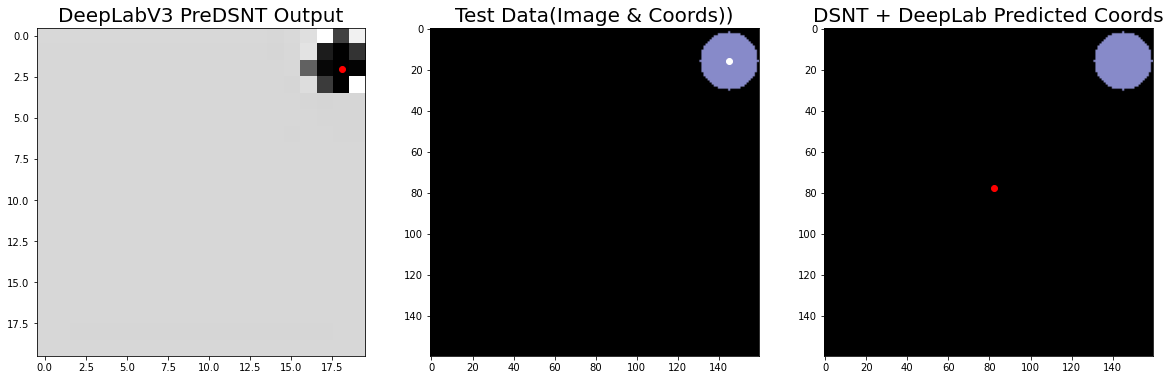

In [199]:
inputs = model.input   
outputs= model.get_layer('last').output

pureDLV3 = Model(inputs,outputs)
predicts = pureDLV3.predict(test_images) # Used to be test_images
print(predicts.shape)
newPredicts = np.einsum('ijkl->iljk',predicts )
actPredicts = model.predict(test_images)

for numImage in range(3,6):
    f, ax = plt.subplots(1, 3, figsize=(20,20))   
    ax[0].imshow((newPredicts[numImage][0]),cmap="gray")
    ax[0].scatter(((newPredicts[numImage][0].shape[0]) * test_targets[numImage][0][0]),((newPredicts[numImage][0].shape[0]) * test_targets[numImage][0][1]),c = 'red') # Used to be test_targets
    ax[0].set_title( "DeepLabV3 PreDSNT Output", fontsize=20)

    ax[1].imshow(test_images[numImage].astype('uint8')) # Used to be test_images
    ax[1].scatter((160 * test_targets[numImage][0][0]),(160 * test_targets[numImage][0][1]),c = 'white')
    ax[1].set_title( "Test Data(Image & Coords))", fontsize=20)

    ax[2].imshow(test_images[numImage].astype('uint8')) # Used to be test_images
    ax[2].scatter((160 * actPredicts[numImage][0][0]),(160 * actPredicts[numImage][0][1]),c = 'red')
    ax[2].set_title( "DSNT + DeepLab Predicted Coords", fontsize=20)

[[[0.52906275 0.54440373]]

 [[0.05466106 0.32836694]]

 [[0.2918365  0.59976214]]

 [[0.5515361  0.5708477 ]]

 [[0.12454651 0.4431867 ]]]
(50, 1, 2)


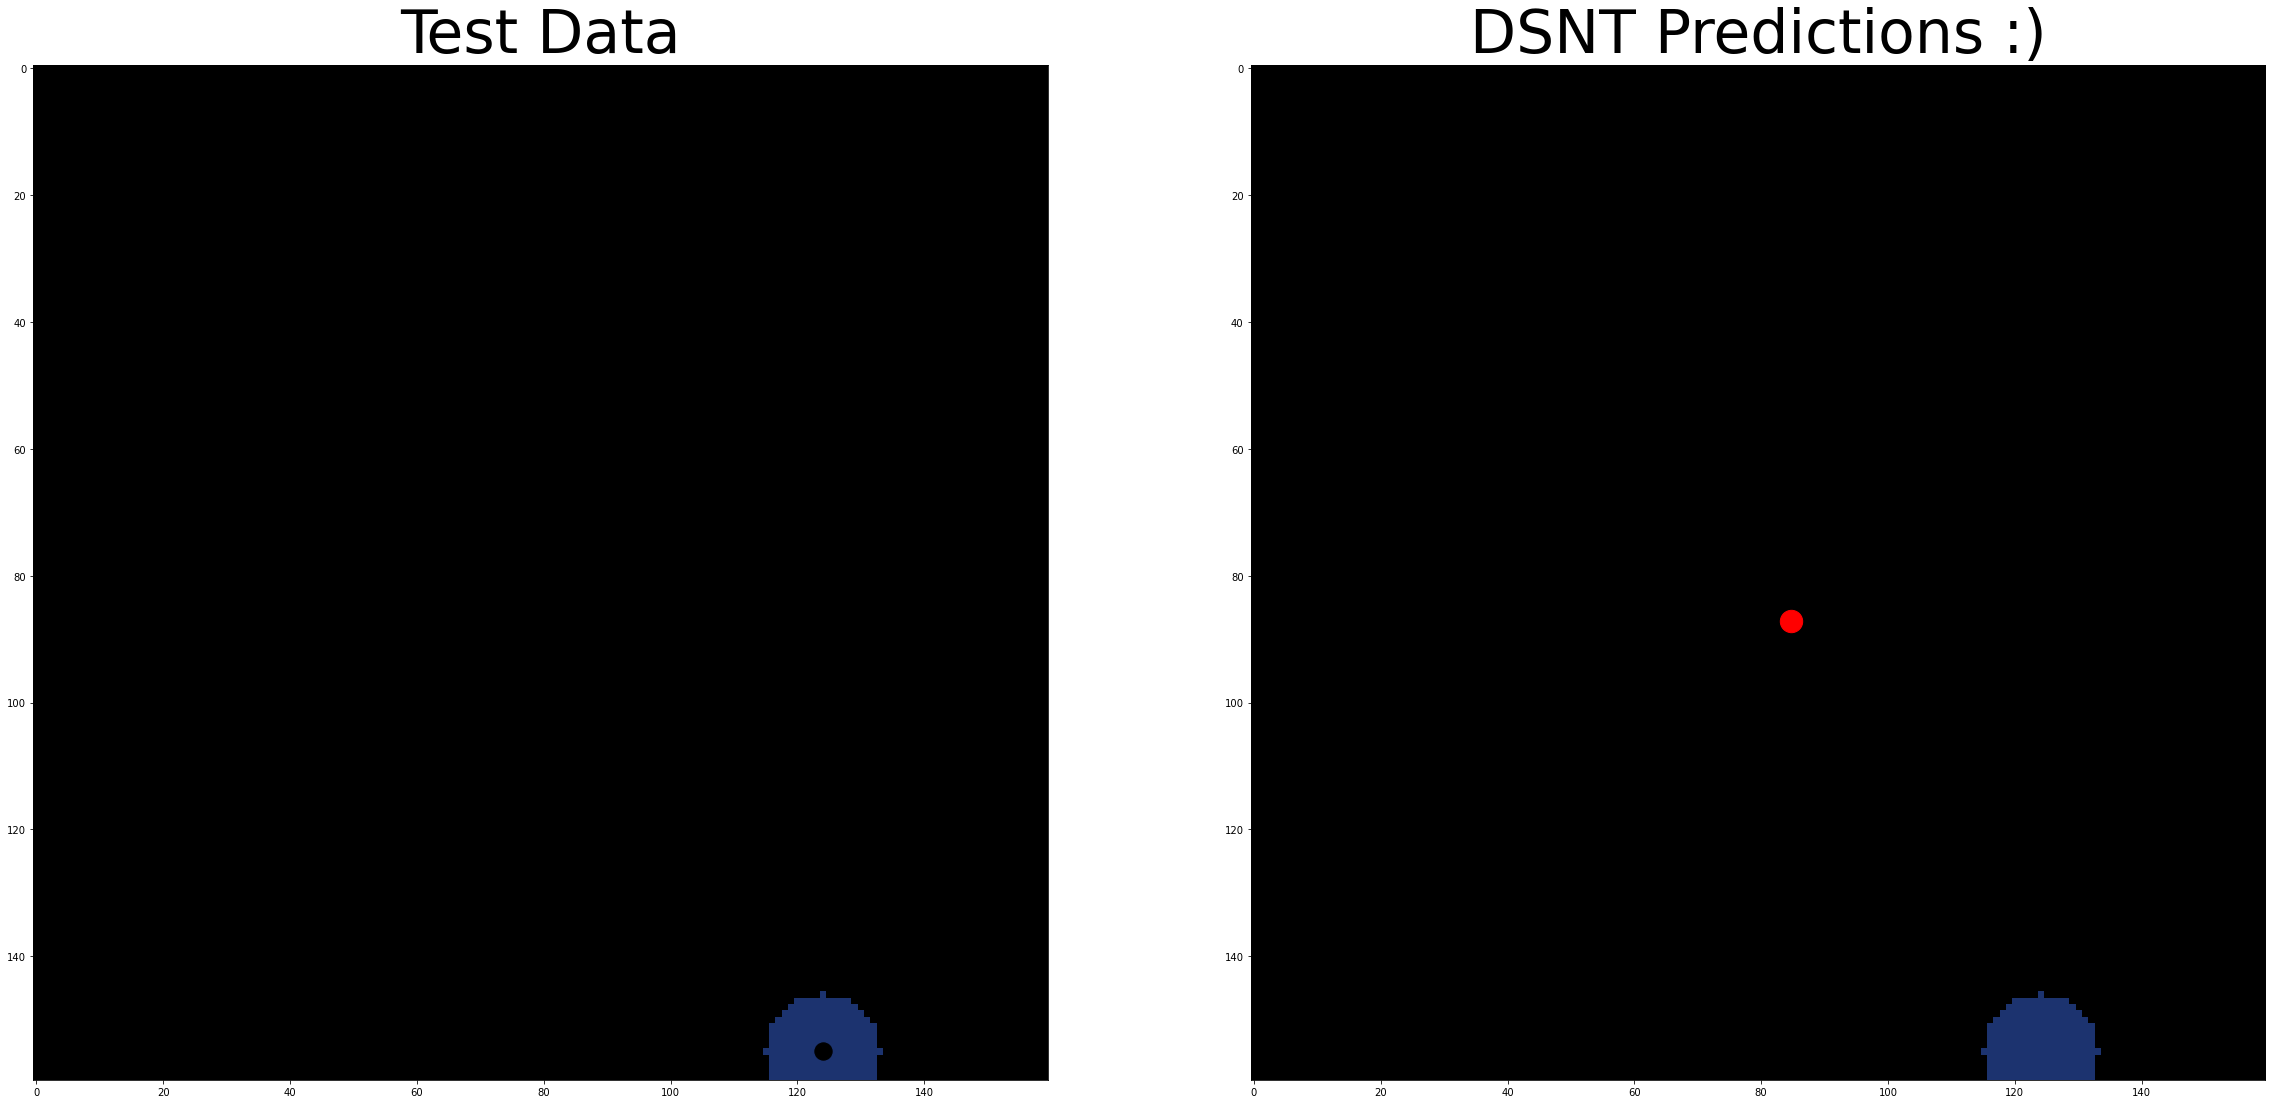

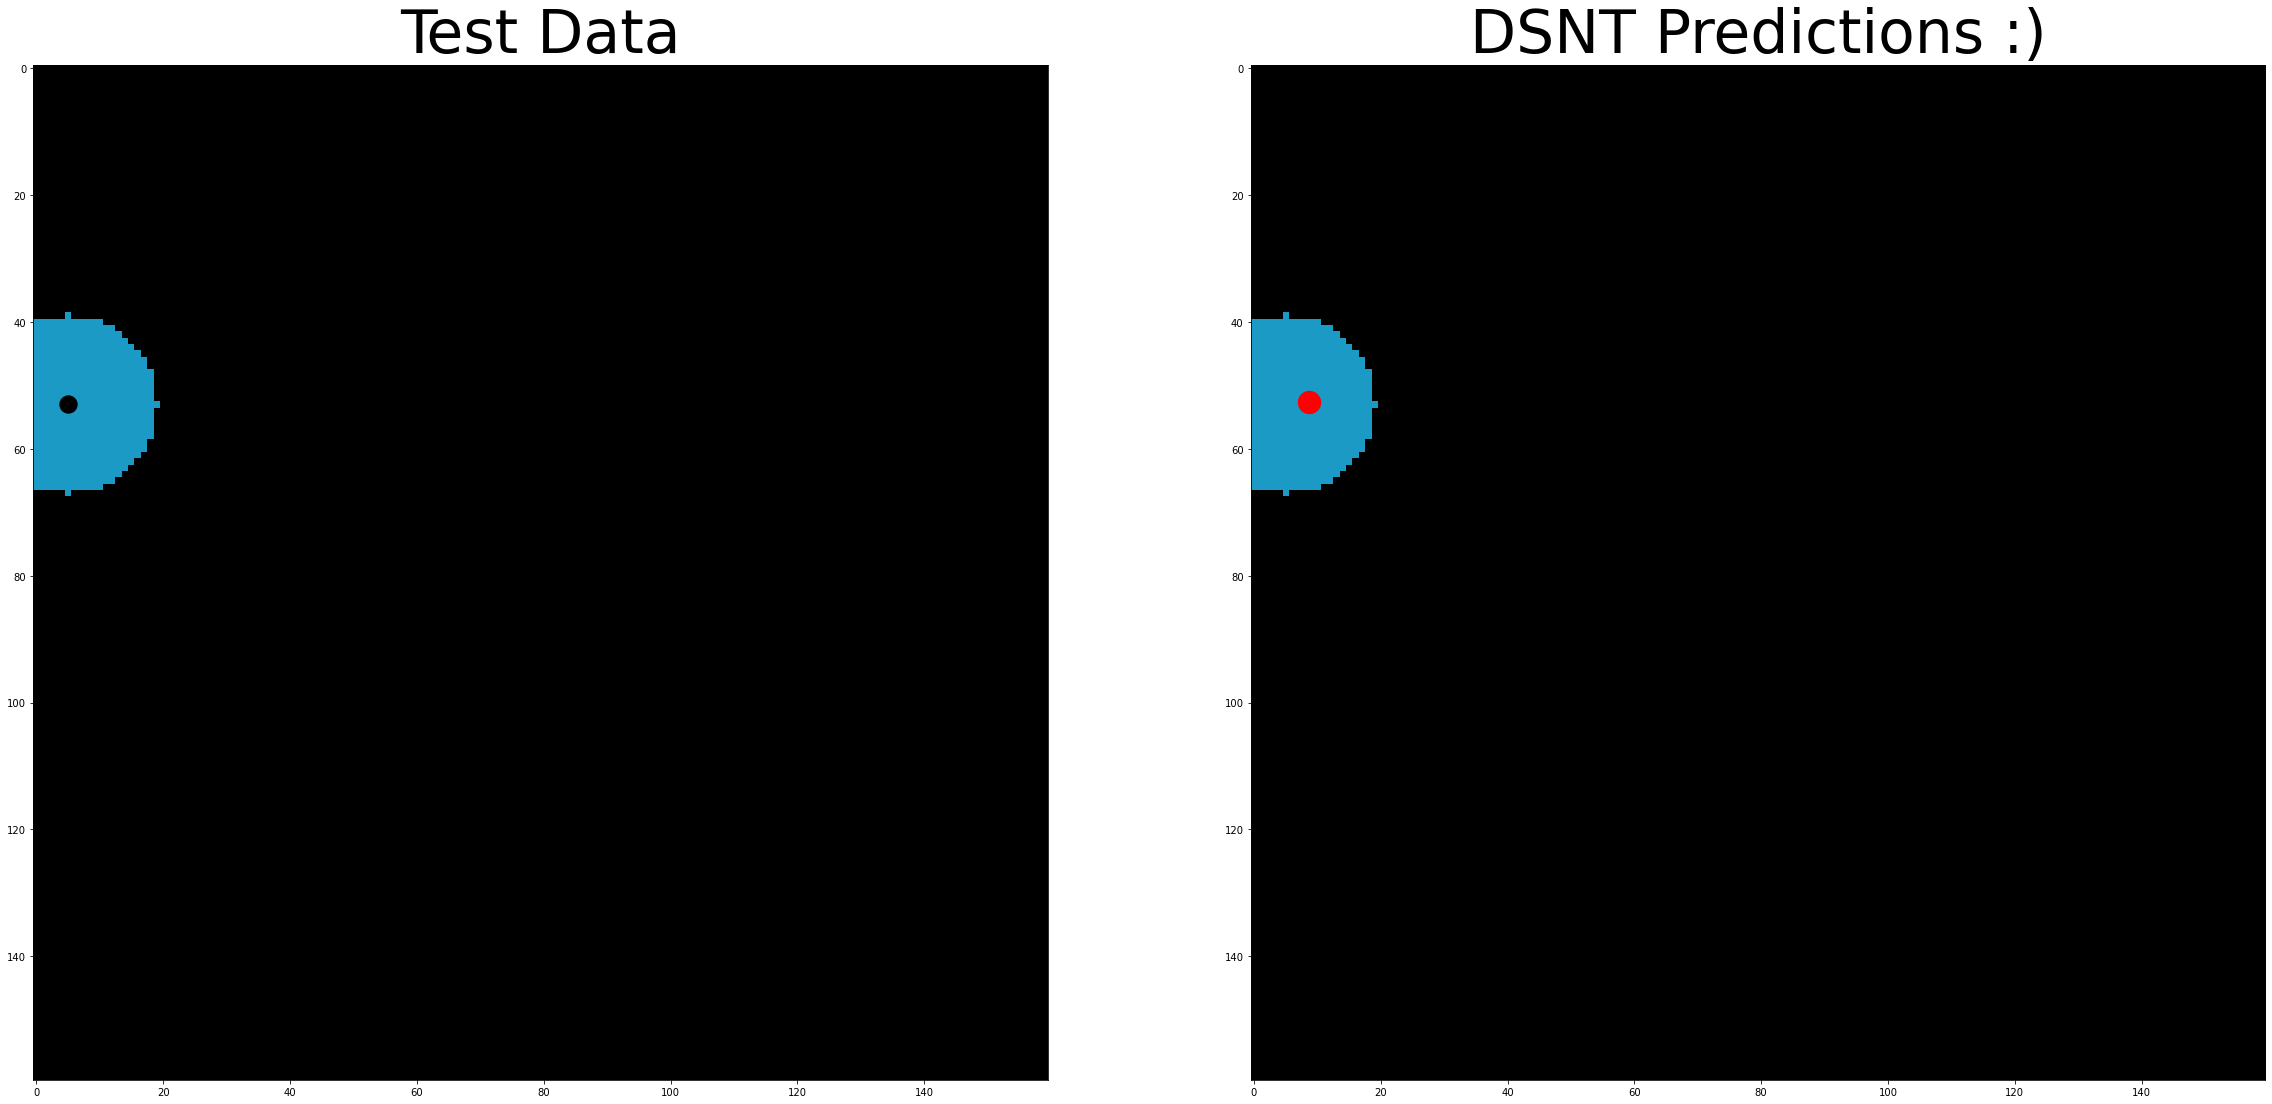

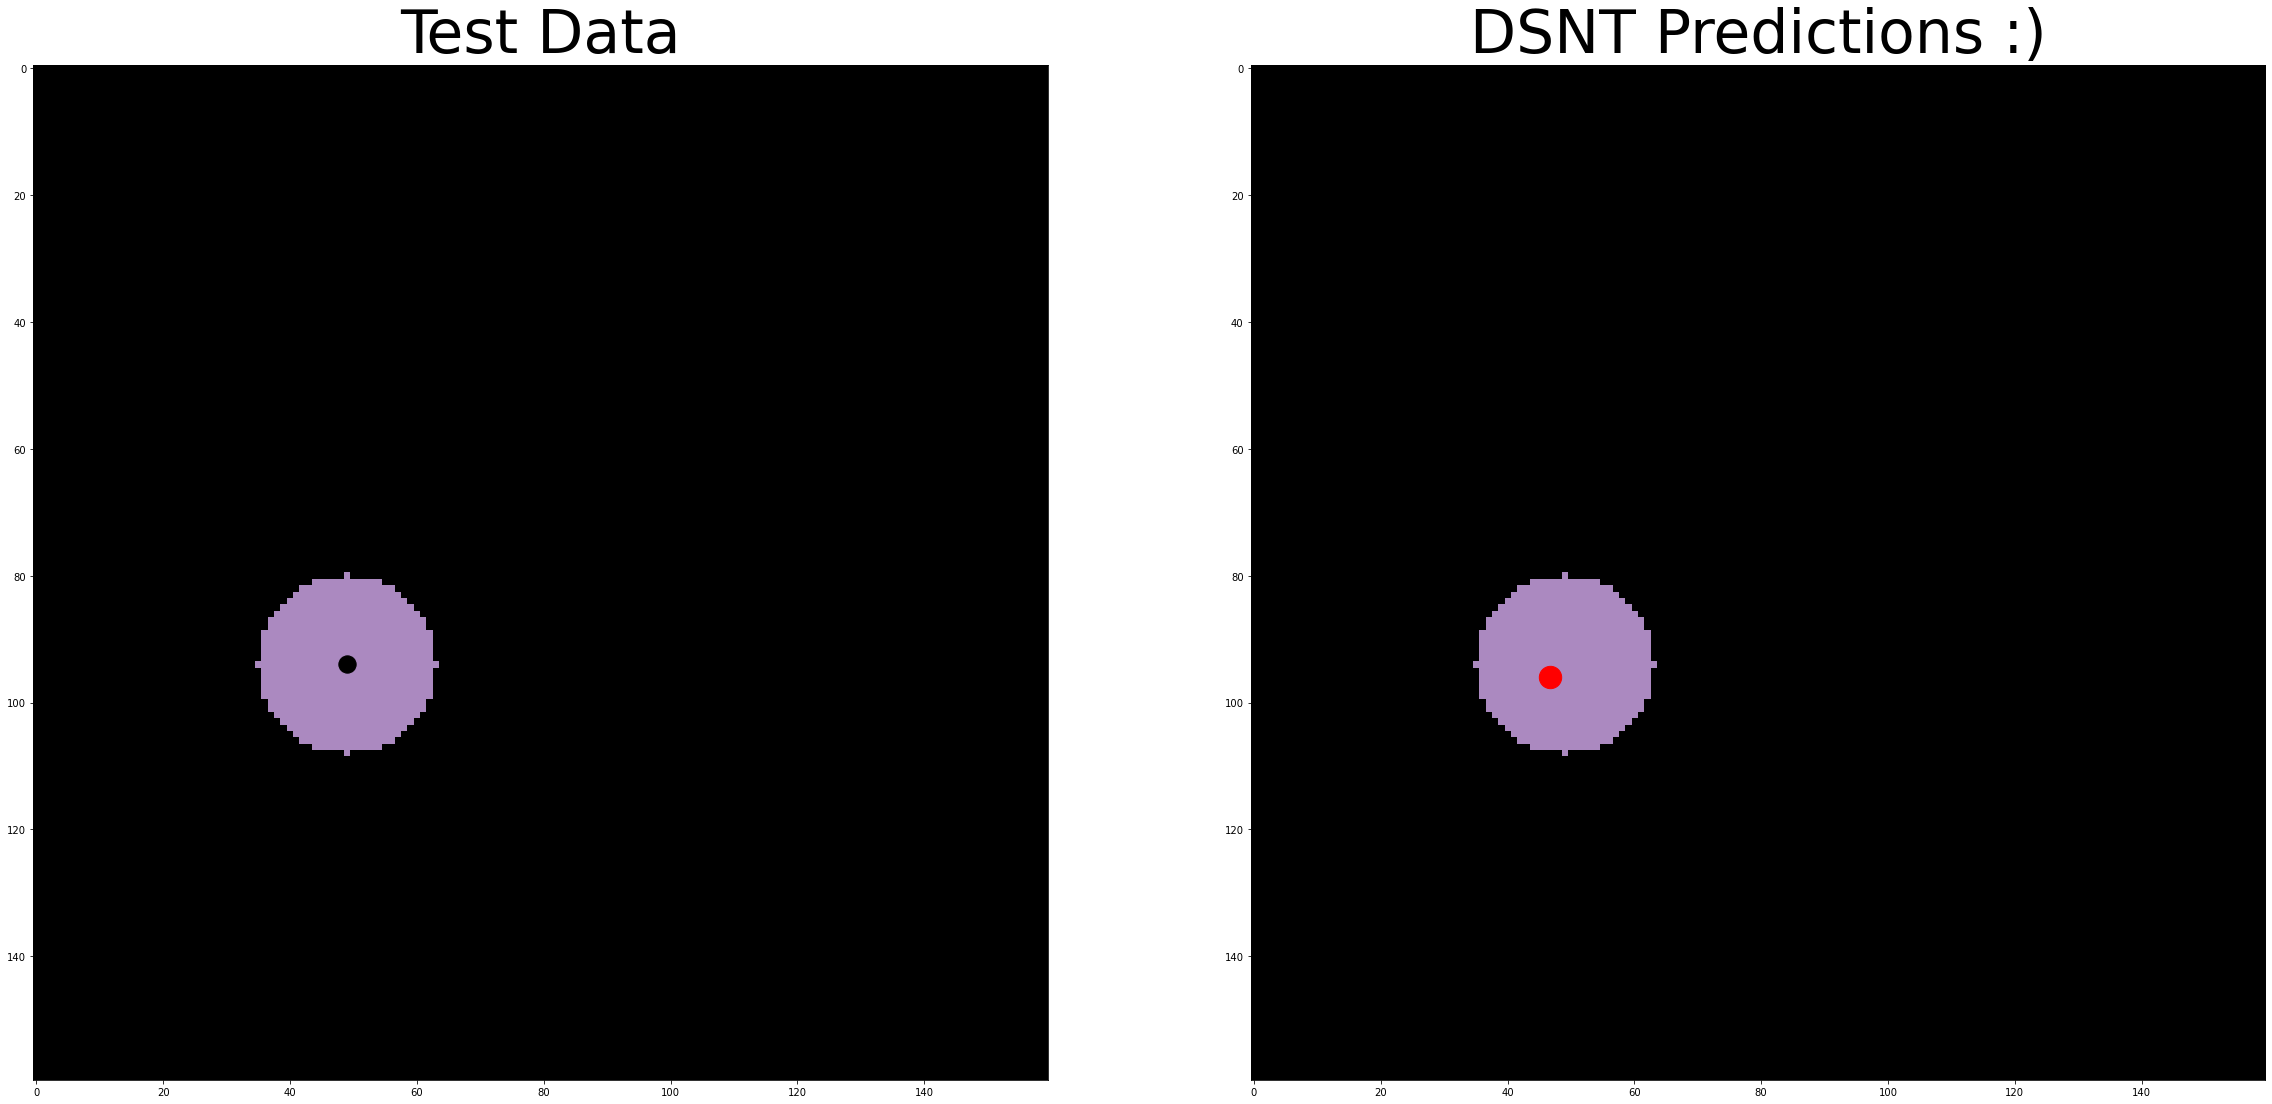

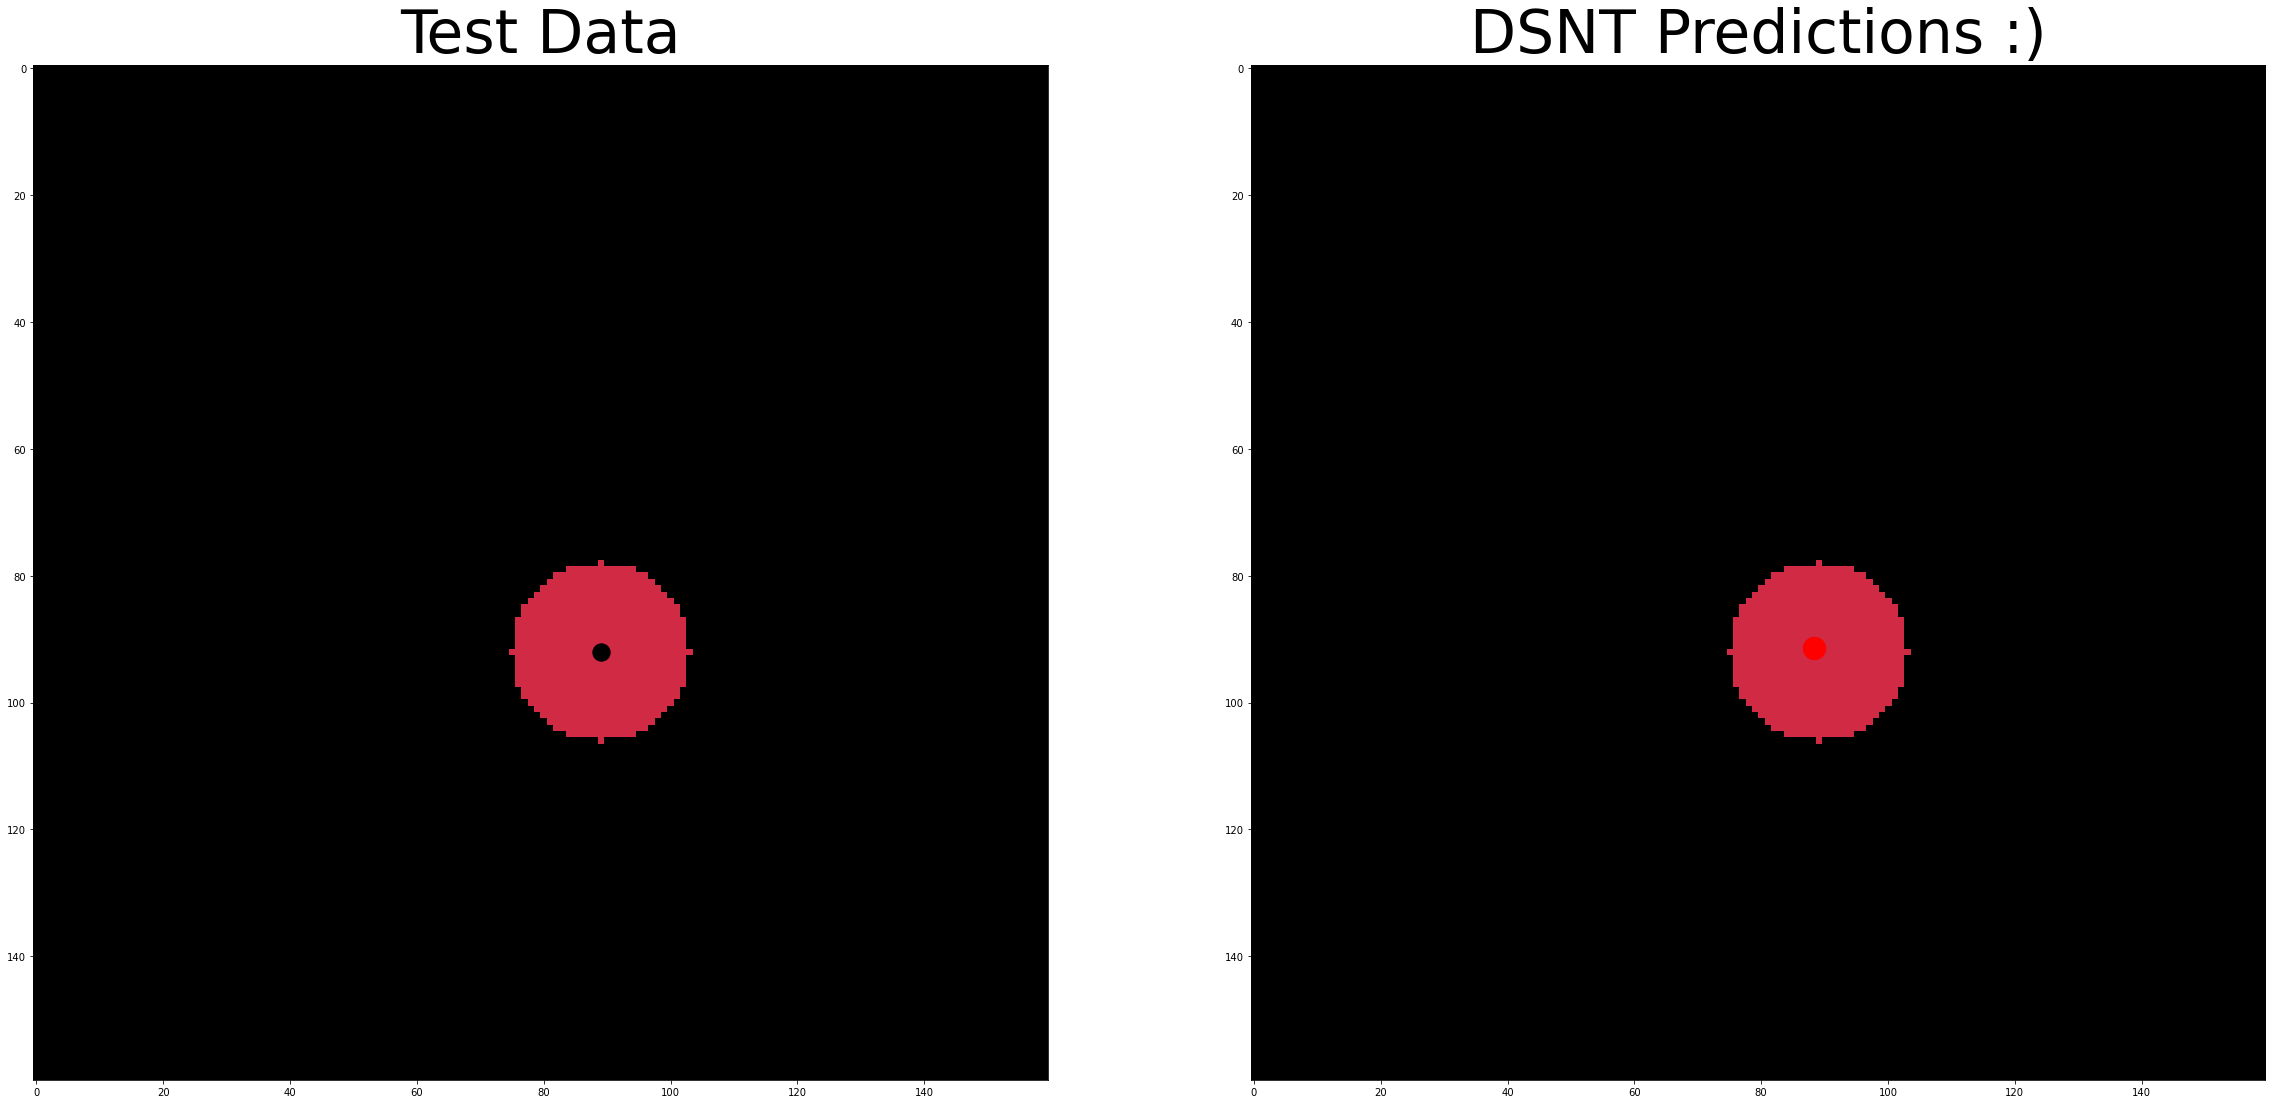

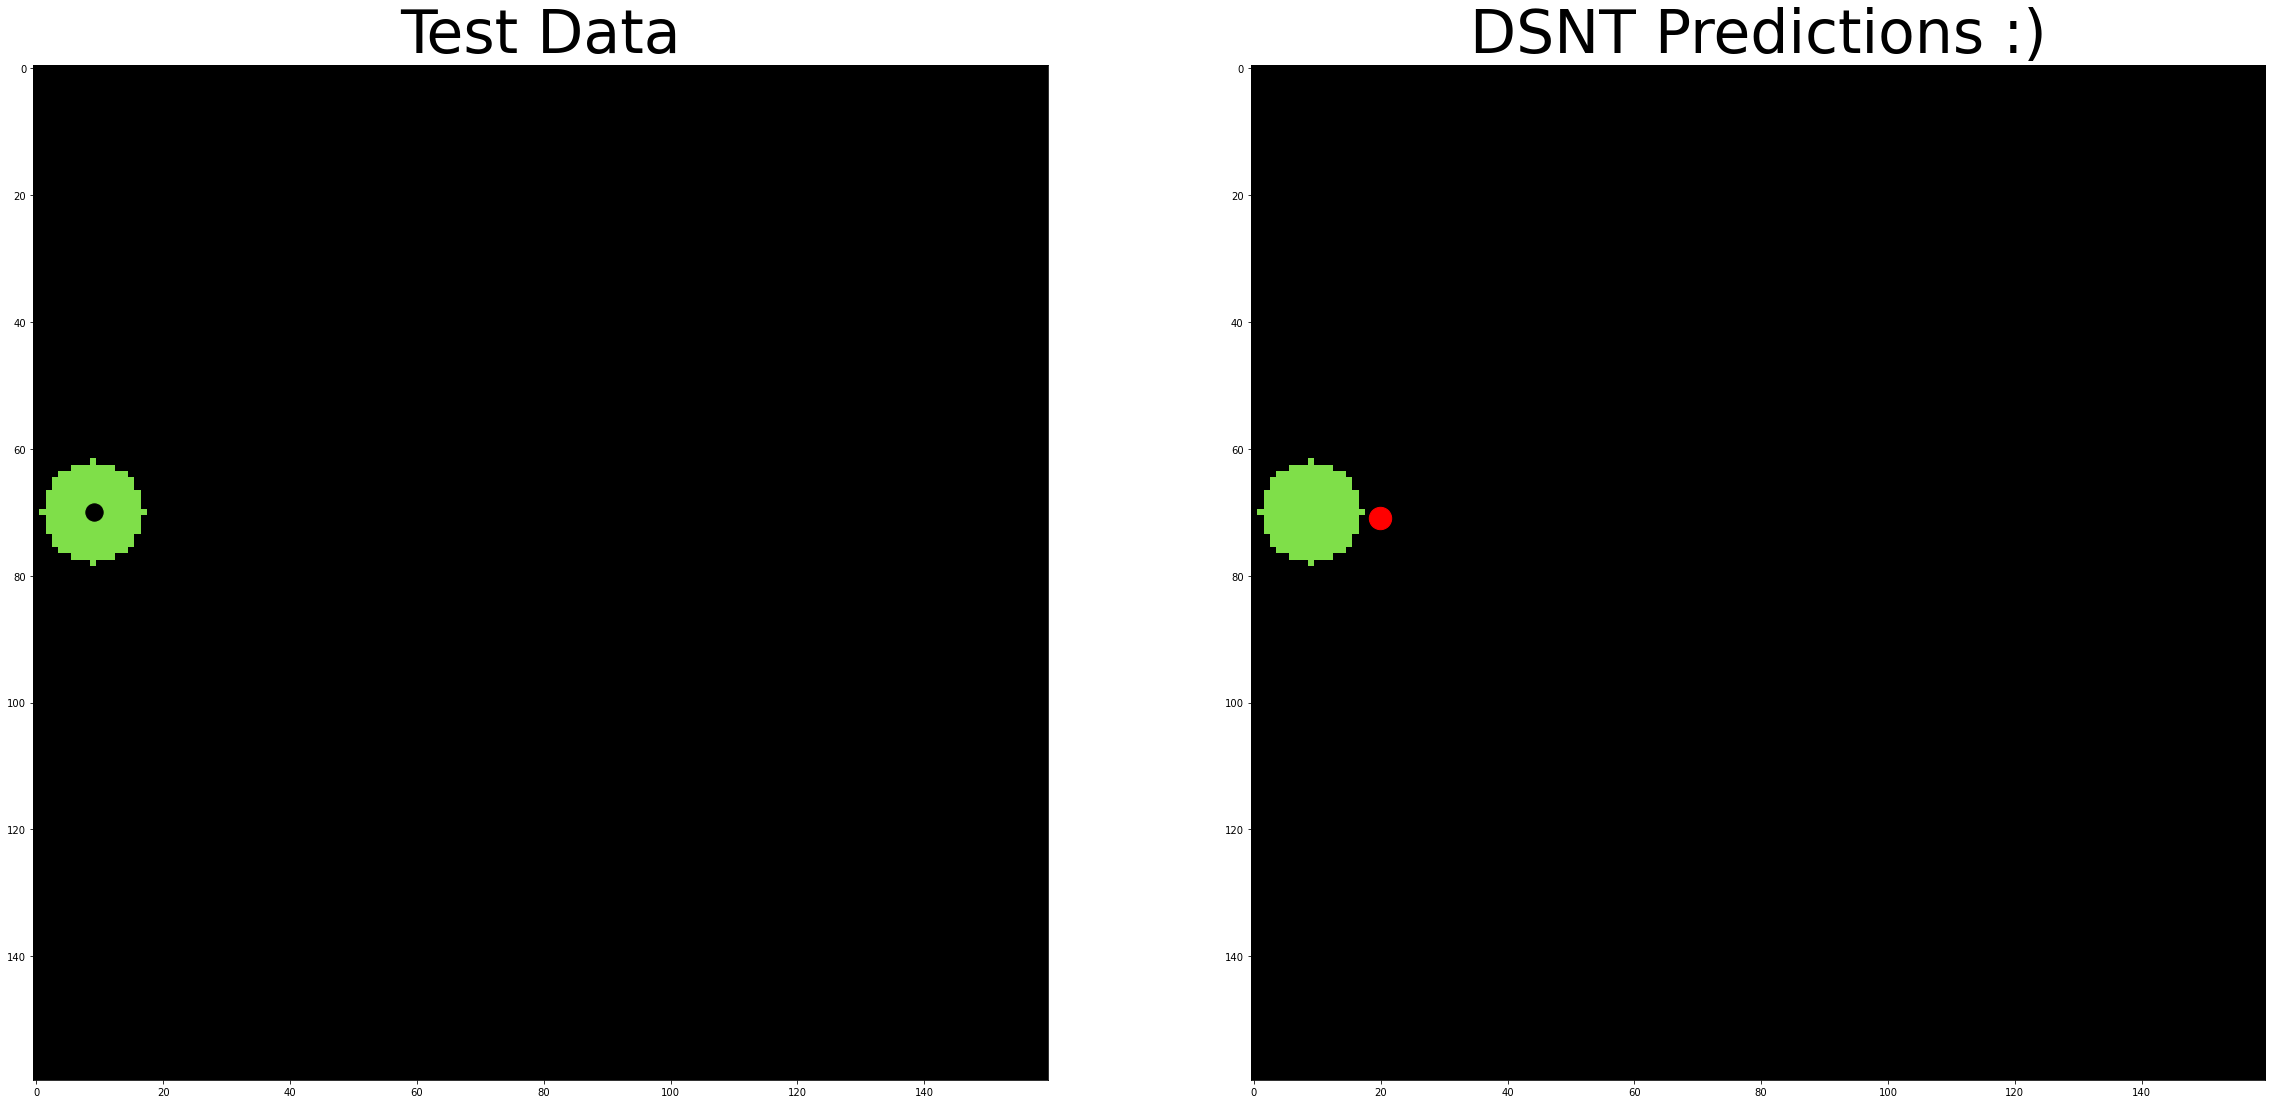

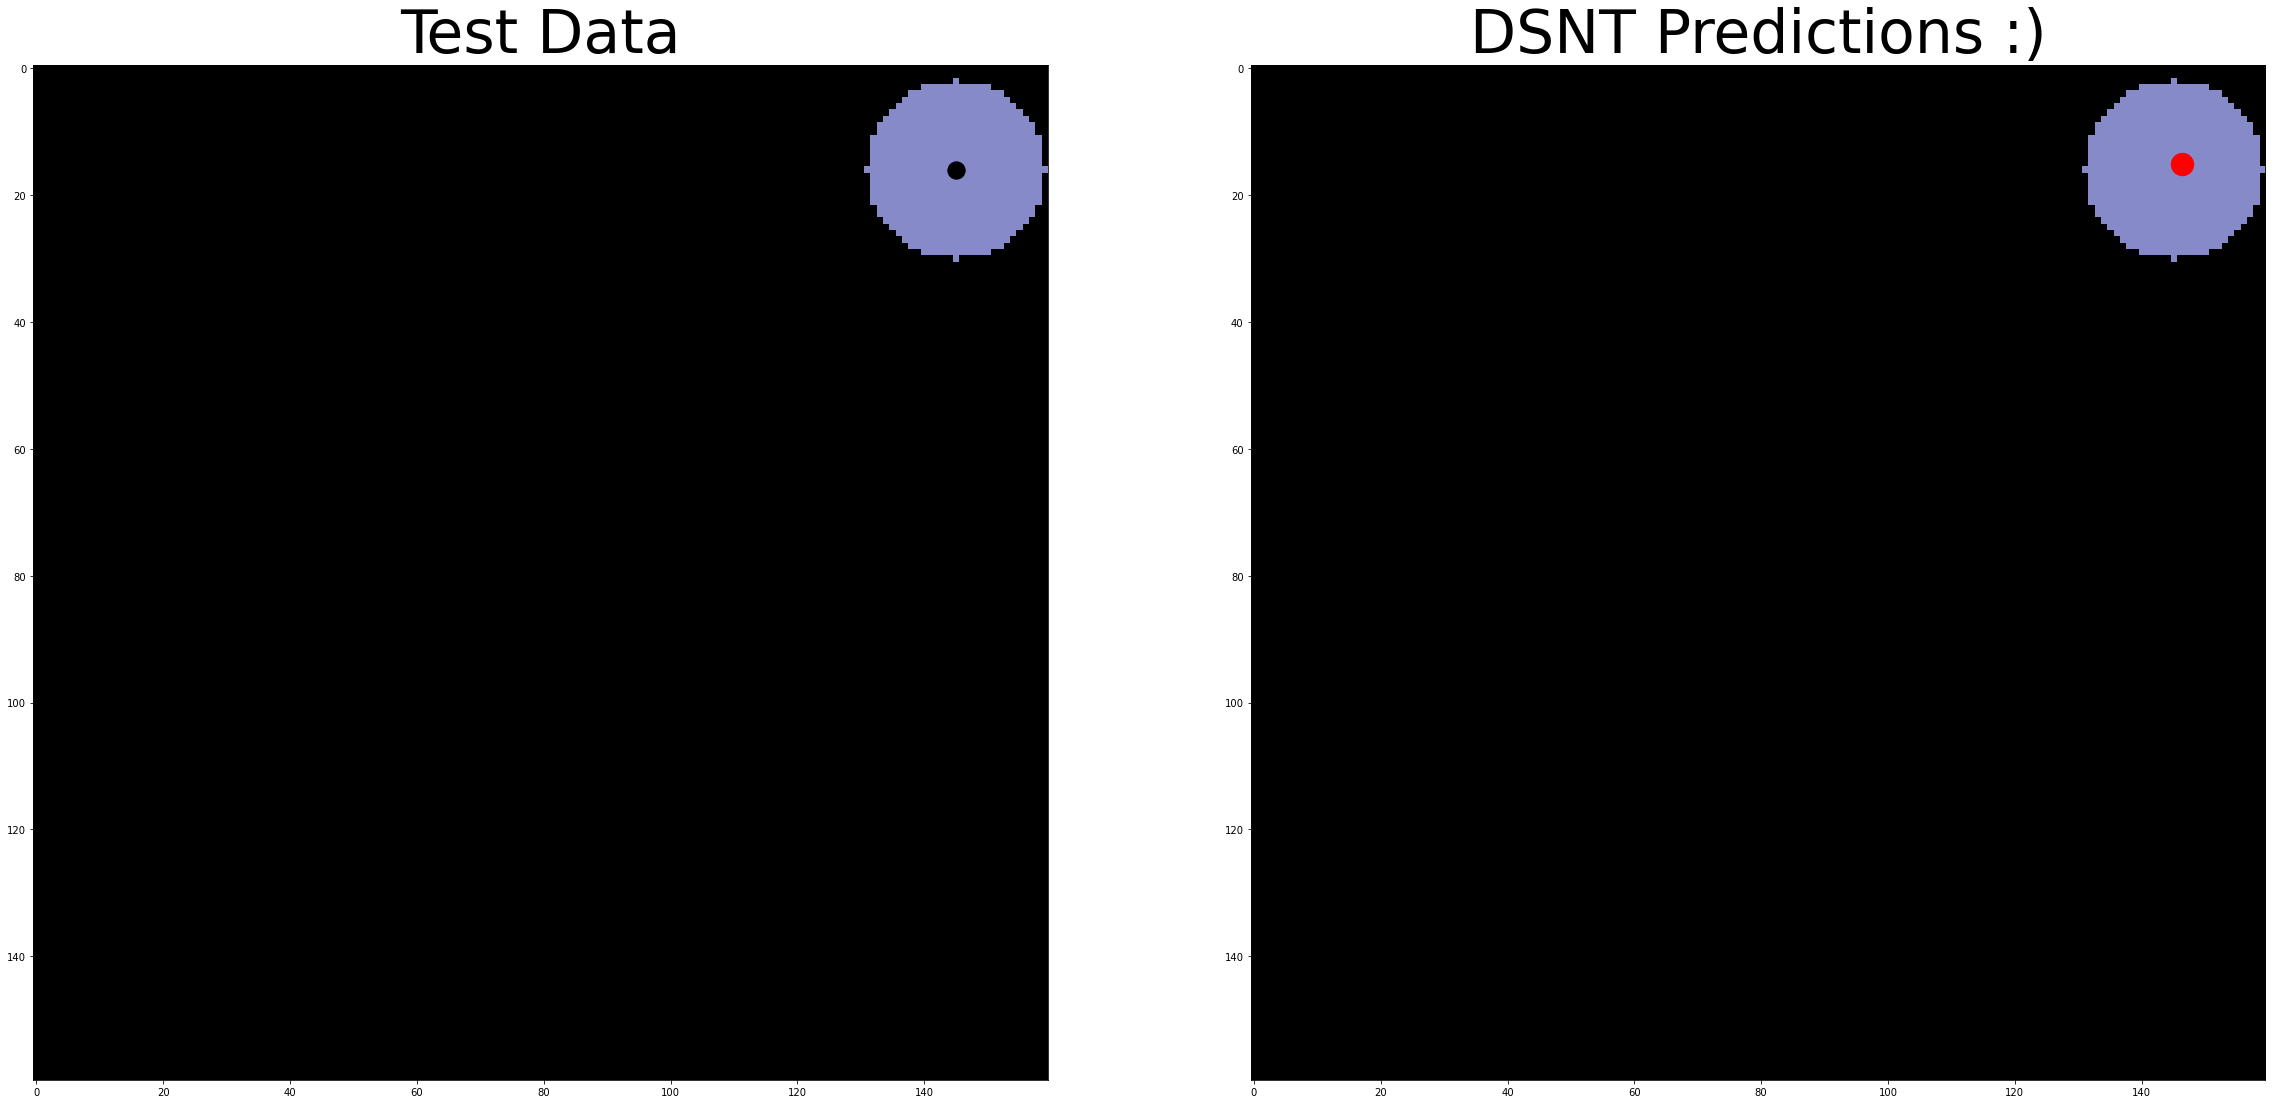

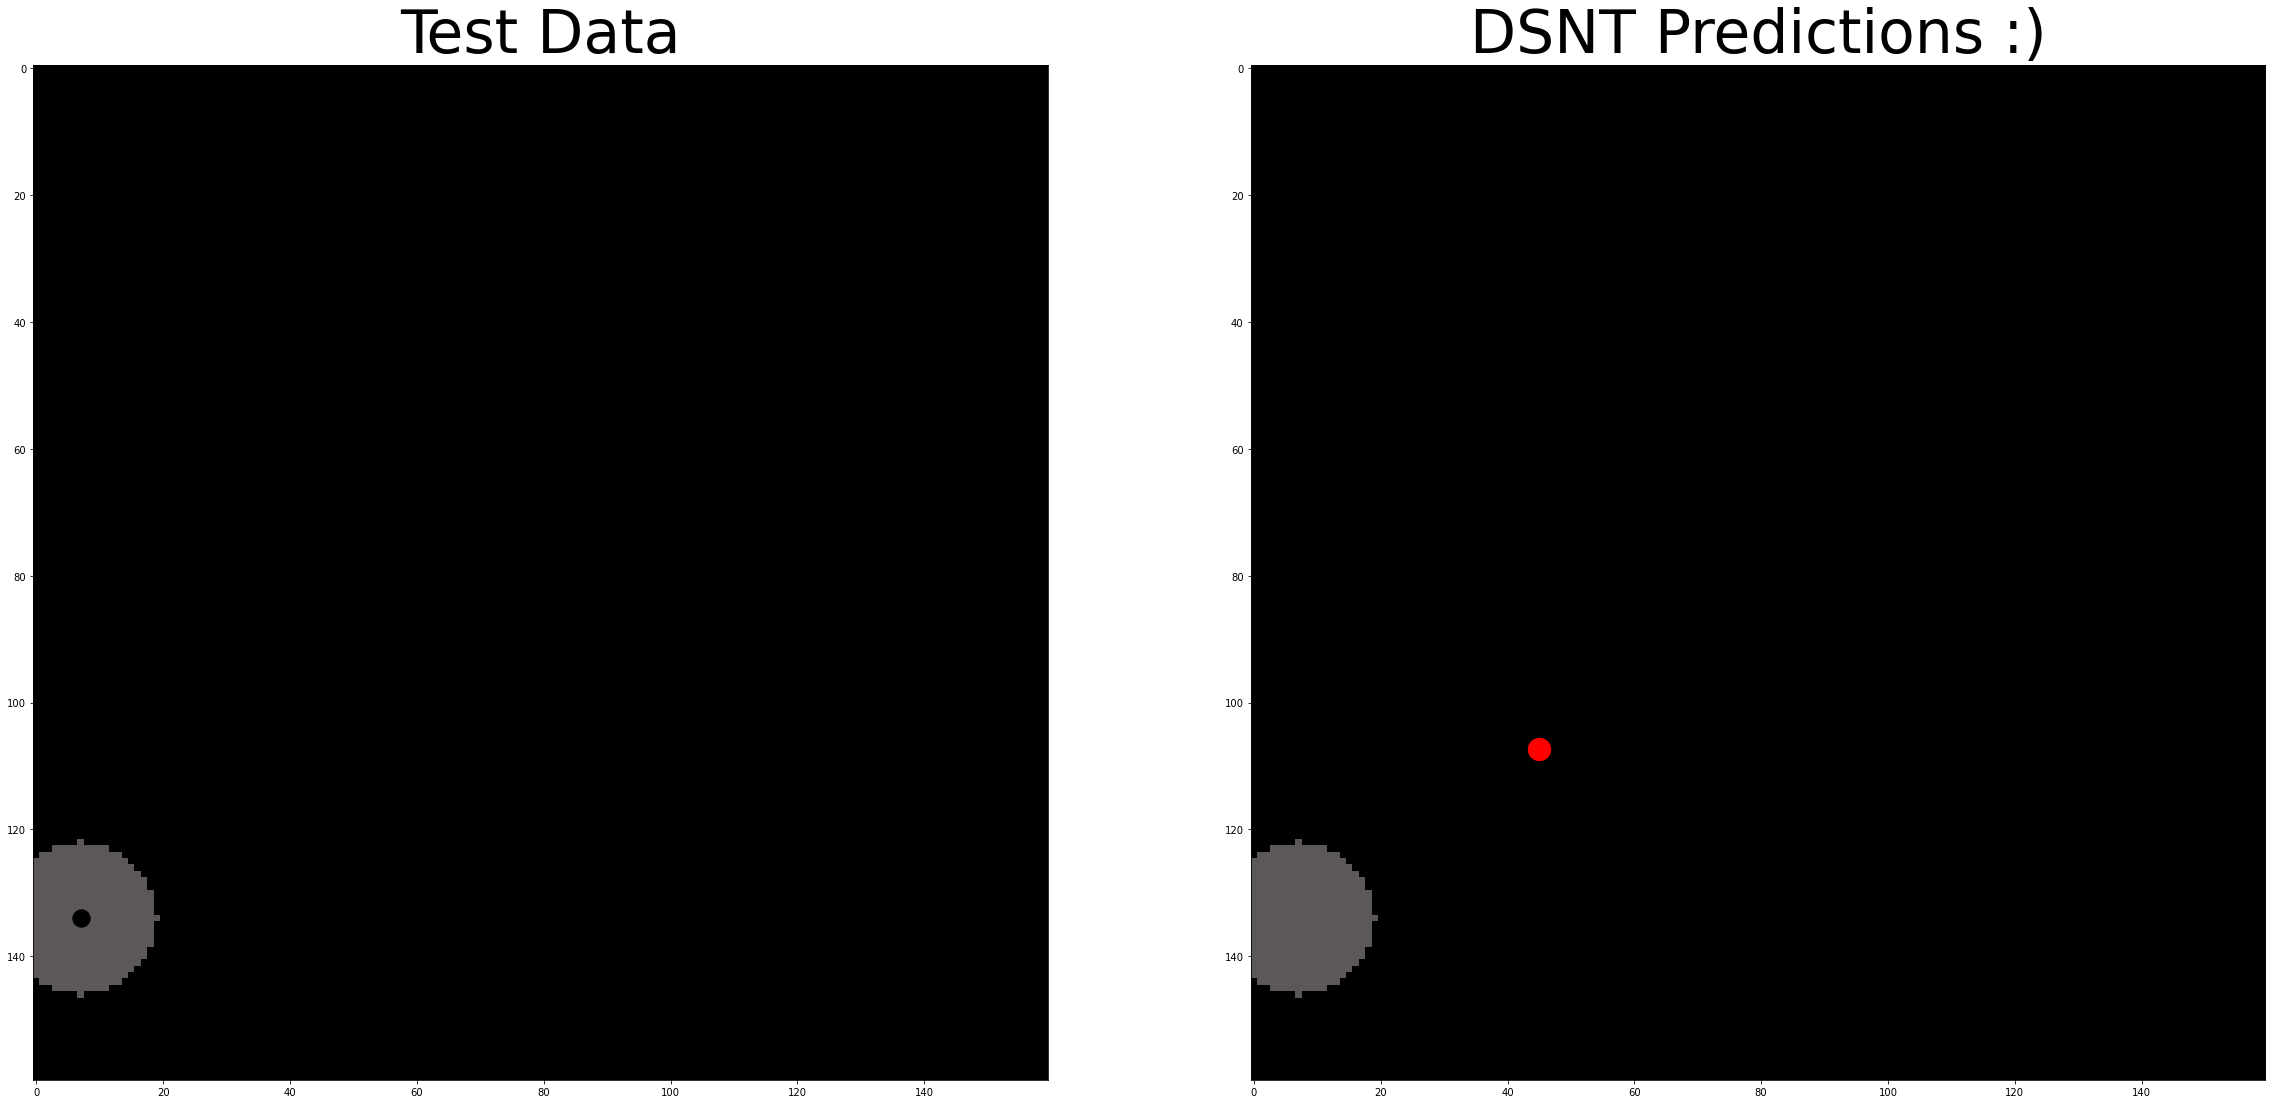

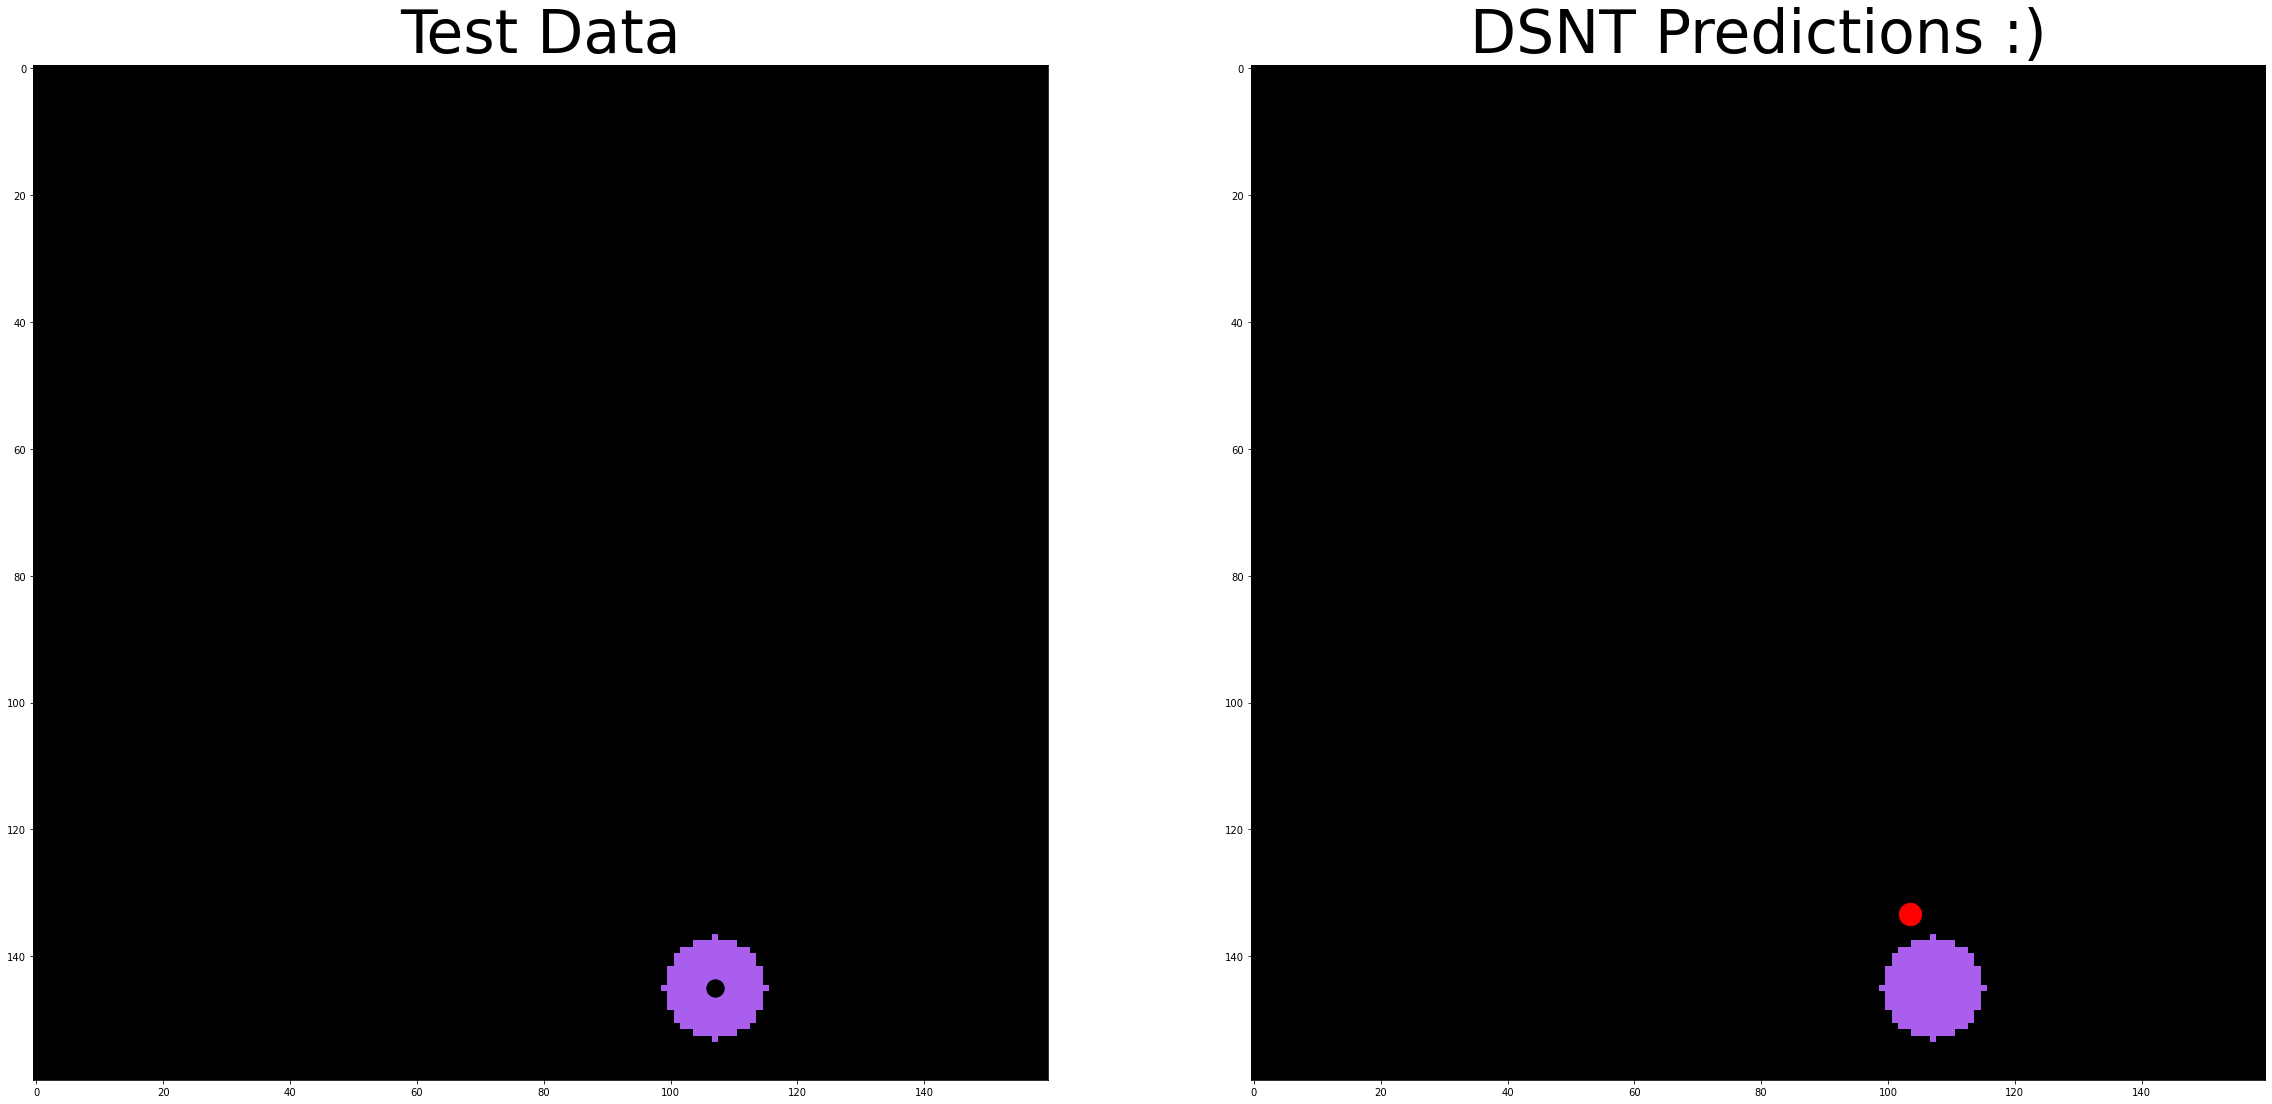

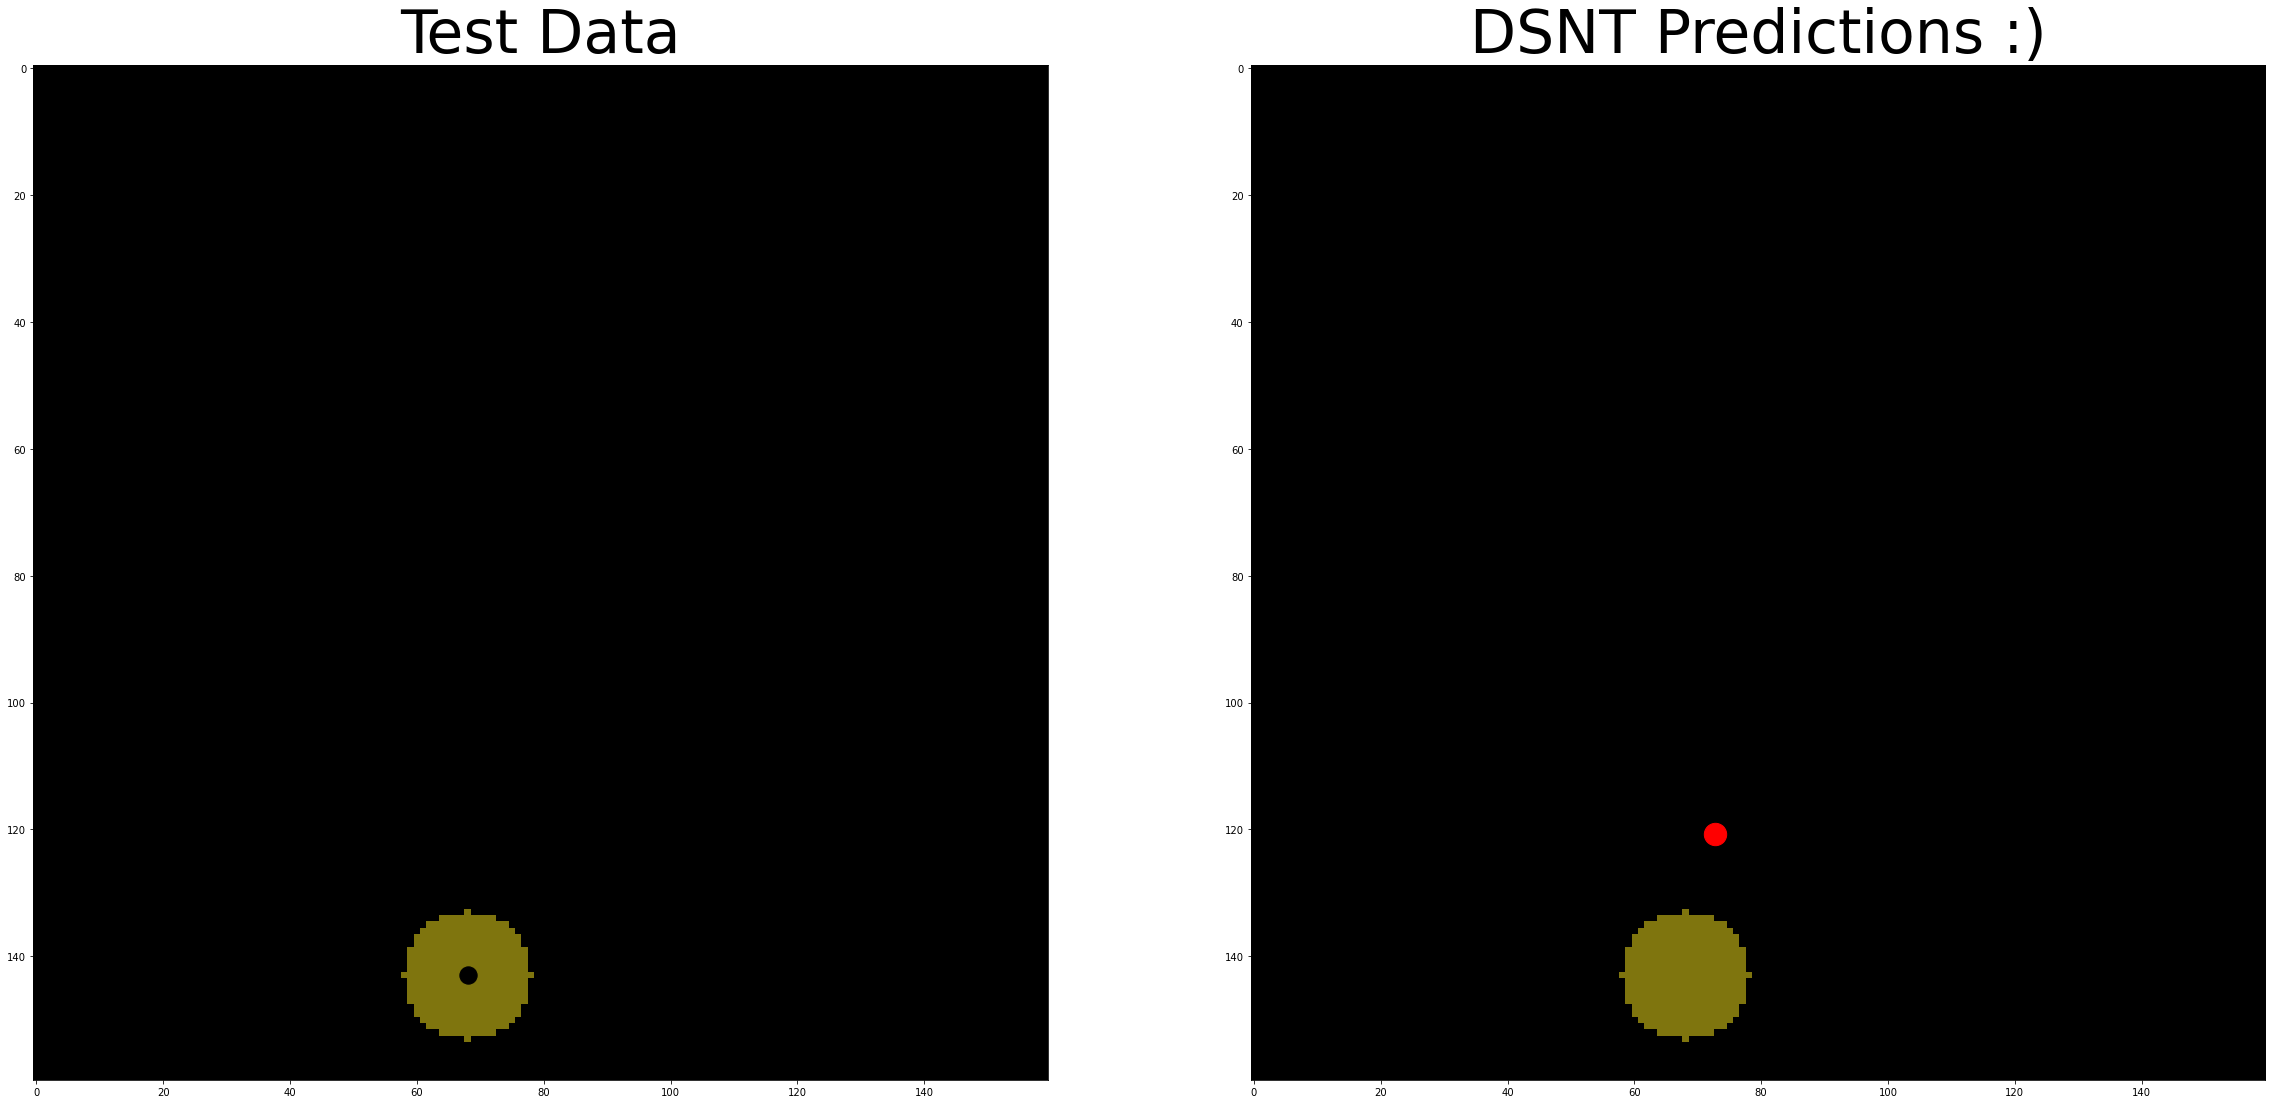

In [138]:
import copy
predictions = model.predict(test_images)
print(predictions[:5])
predictionPts =copy.deepcopy(predictions)
predictionPts *= 160
yTestPts = copy.deepcopy(test_targets)
yTestPts *=160

print(predictions.shape)

# Format of data is (Row Number aka image associated with, Specific Landmark, X & Y Coordinate)
for n in range(9):
    f, ax = plt.subplots(1, 2, figsize=(40,40))

    ax[0].scatter(yTestPts[n][0][0], yTestPts[n][0][1],s=300, c = 'black')
    ax[0].imshow(test_images[n].astype('uint8'))
    ax[0].set_title( "Test Data", fontsize=60)


    ax[1].scatter(predictionPts[n][0][0], predictionPts[n][0][1],s=500, c = 'red')
    ax[1].imshow(test_images[n].astype('uint8'))
    ax[1].set_title( "DSNT Predictions :)", fontsize=60)

